# Skype Image Test

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False  # can also be set in the trainer

## Environment

In [ ]:
import os

os.chdir("..")

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

# CENTER PLOTS
from IPython.core.display import HTML

display(
    HTML(
        """ <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""
    )
)

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

sys.path.append("notebooks")

torch.set_num_threads(N_THREADS)

# Dataset 

- MNIST
- CelebA32
- CelebA64

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split
from utils.visualize import plot_dataset_samples_imgs, plot_losses

In [5]:
celeba_train, celeba_test = train_dev_split(
    get_dataset("celeba32")(), dev_size=0.1, is_stratify=False
)
train_datasets = {"celeba32": celeba_train}

In [6]:
from neuralproc.utils.datasplit import (
    GridCntxtTrgtGetter,
    RandomMasker,
    half_masker,
    no_masker,
)

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(
    context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
    target_masker=no_masker,
    is_add_cntxts_to_trgts=False,
)

# Model

In [7]:
X_DIM = 2  # 2D spatial input

In [8]:
from functools import partial

from neuralproc import (
    AttentiveNeuralProcess,
    ConvolutionalProcess,
    NeuralProcessLoss,
    RegularGridsConvolutionalProcess,
    merge_flat_input,
)
from neuralproc.predefined import CNN, MLP, ResConvBlock, SelfAttention, UnetCNN

In [9]:
from train_imgs import get_model

# models that take into account the grid
models = {}
models["GridedCCP"] = get_model("GridedCCP")
models["SelfAttnCNP"] = get_model("SelfAttnCNP")

In [10]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {
        data_name: {
            model_name: partial(model, y_dim=data_train.shape[0])
            for model_name, model in models.items()
        }
        for data_name, data_train in datasets.items()
    }

## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [11]:
chckpnt_dirname = "results/iclr_bug/"

In [12]:
from functools import partial

import skorch
from neuralproc import NeuralProcessLoss
from utils.data import cntxt_trgt_collate
from utils.train import train_models

kwargs = dict(
    chckpnt_dirname=chckpnt_dirname,
    is_retrain=False,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of data for validation
    patience=10,
    batch_size=16,
    seed=123,
)

trainers = train_models(
    train_datasets,
    add_y_dim(models, train_datasets),
    NeuralProcessLoss,
    iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_return_masks=True),
    iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_return_masks=True),
    **kwargs
)


--- Loading celeba32/GridedCCP/run_0 ---

celeba32/GridedCCP/run_0 | best epoch: 20 | train loss: -3.2533 | valid loss: -3.3138 | test log likelihood: None

--- Loading celeba32/SelfAttnCNP/run_0 ---



/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


celeba32/SelfAttnCNP/run_0 | best epoch: 20 | train loss: -3.3434 | valid loss: -3.2814 | test log likelihood: None


/private/home/yannd/.conda/envs/neuralproc/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


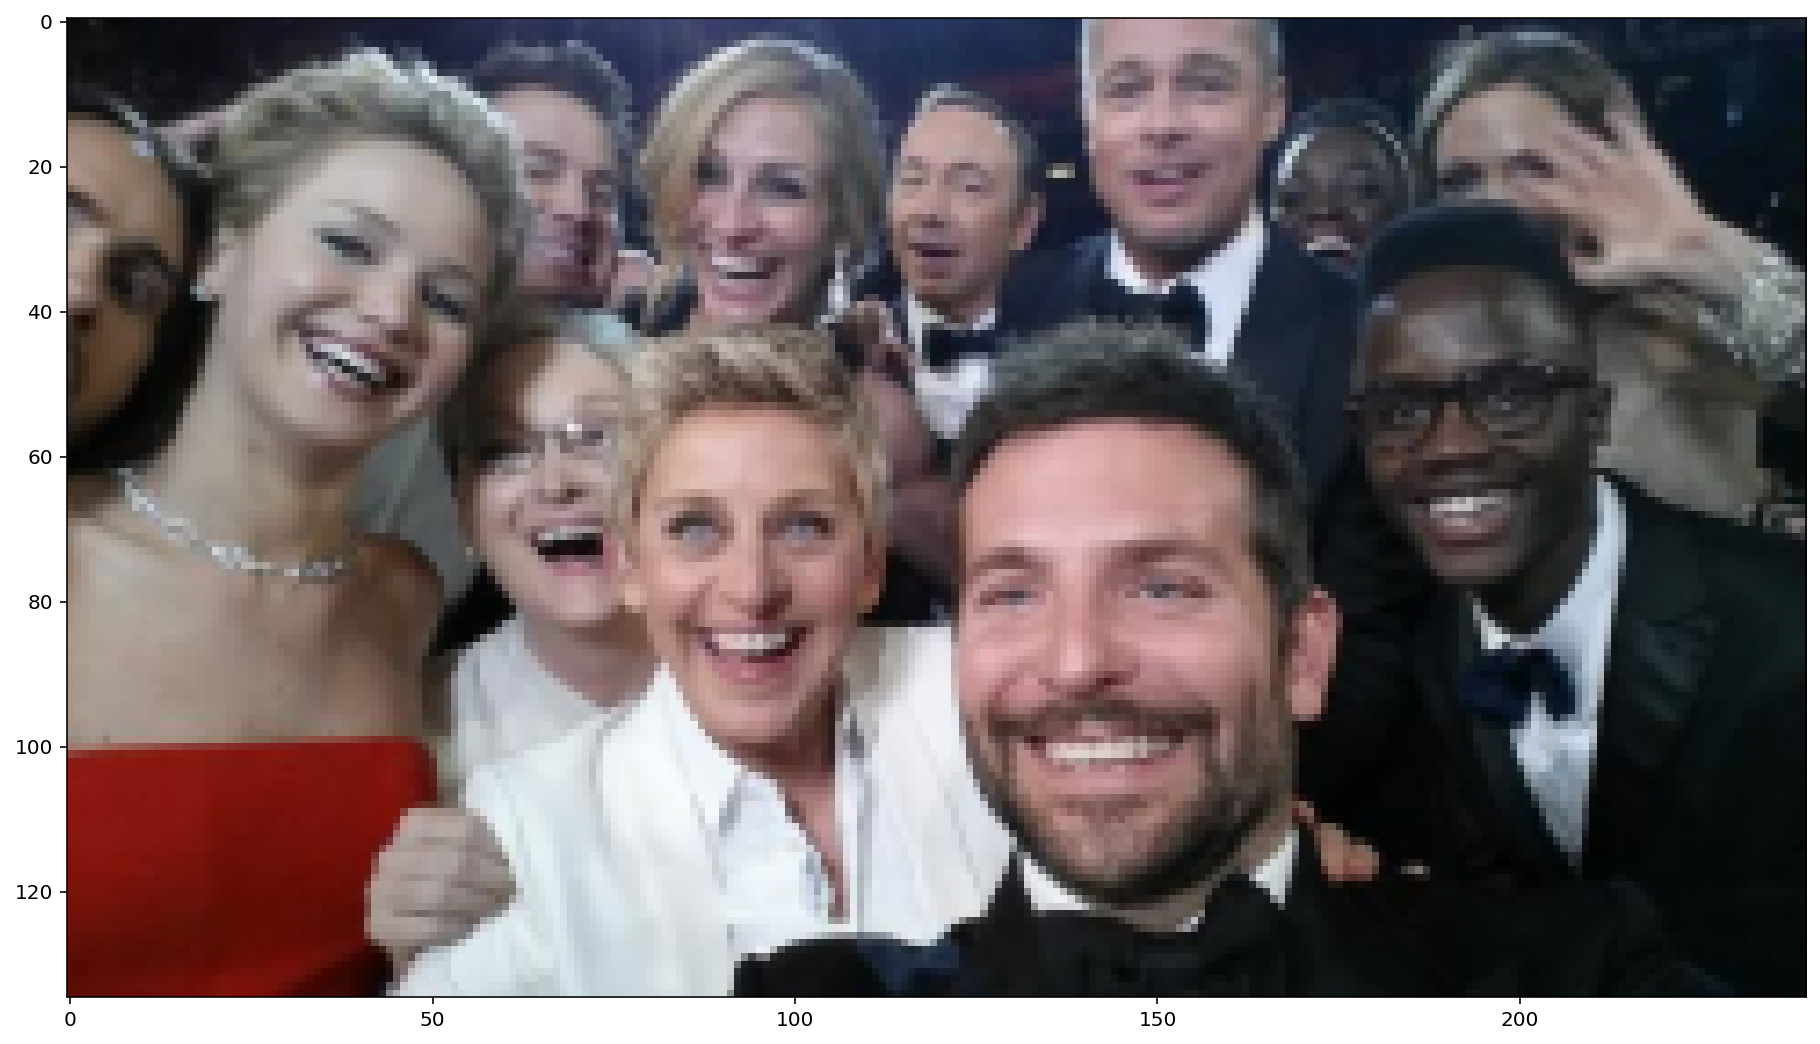

In [13]:
import matplotlib.image as mpimg
from skimage.transform import downscale_local_mean, rescale, resize

img = mpimg.imread("notebooks/ellen_selfie_oscars.jpg")
down_img = rescale(img, 0.4)
fig, ax = plt.subplots(1, 1, figsize=(17, 9))
imgplot = ax.imshow(down_img)

In [14]:
down_img.shape

(135, 240, 3)

In [15]:
from torch.utils.data import Dataset
from torchvision import transforms

COLOUR_BLACK = torch.tensor([0.0, 0.0, 0.0])


class SingleImage(Dataset):
    def __init__(
        self,
        img,
        transforms_list=[transforms.ToTensor()],
        missing_px_color=COLOUR_BLACK,
    ):
        self.shape = down_img.shape[-1:] + down_img.shape[:-1]
        self.missing_px_color = missing_px_color
        self.img = img
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, i):
        return self.transforms(self.img).float(), 0

    def __len__(self):
        return 1

In [16]:
img = SingleImage(
    down_img[..., :3], missing_px_color=torch.tensor([0.0, 0.0, 1.0])
)  # remove transparency

# One Shot Inference 

In [17]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE

In [18]:
def plot_concat(nnz=0.1):
    rm = RandomMasker(min_nnz=nnz, max_nnz=nnz)

    grid_ccp = plot_posterior_img(
        img,
        GridCntxtTrgtGetter(context_masker=rm, target_masker=no_masker),
        trainers["celeba32/GridedCCP/run_0"].module_.cpu(),
        MeanPredictor=VanillaPredictor,
        n_plots=1,
        is_uniform_grid=True,
        is_hrztl_cat=True,
        is_return=True,
    )

    grid_anp = plot_posterior_img(
        img,
        GridCntxtTrgtGetter(context_masker=rm, target_masker=no_masker),
        trainers["celeba32/SelfAttnCNP/run_0"].module_.cpu(),
        MeanPredictor=VanillaPredictor,
        n_plots=1,
        is_uniform_grid=False,
        is_hrztl_cat=True,
        is_return=True,
    )

    out = torch.cat((grid_ccp, grid_anp[:, :, 264:]), dim=2)

    fig, ax = plt.subplots(figsize=(27, 19))
    ax.imshow(out.permute(1, 2, 0).numpy())
    ax.axis("off")

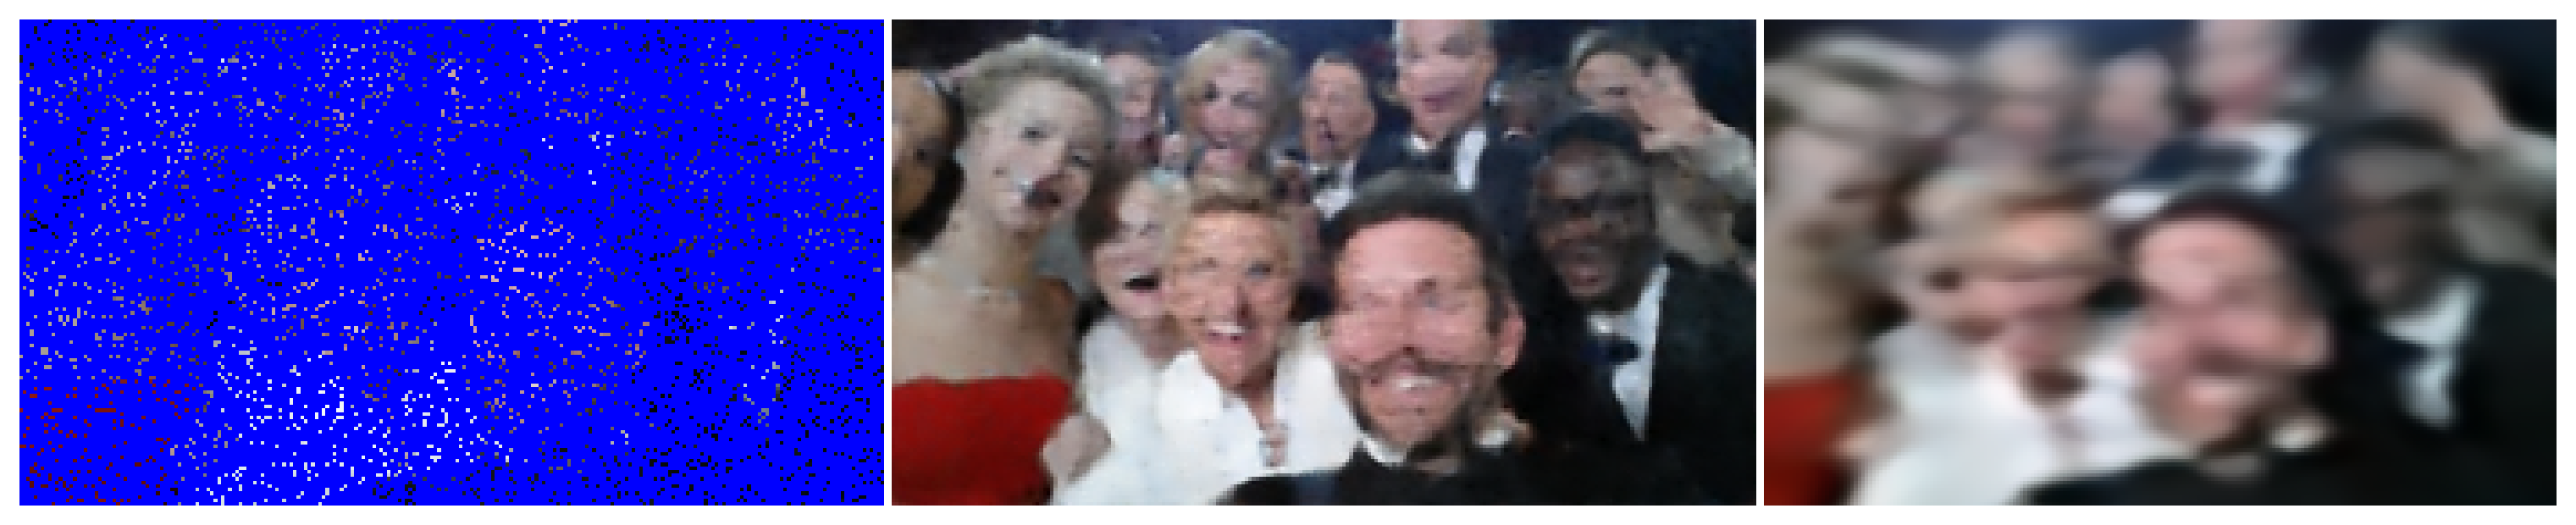

In [19]:
plot_concat(nnz=0.1)

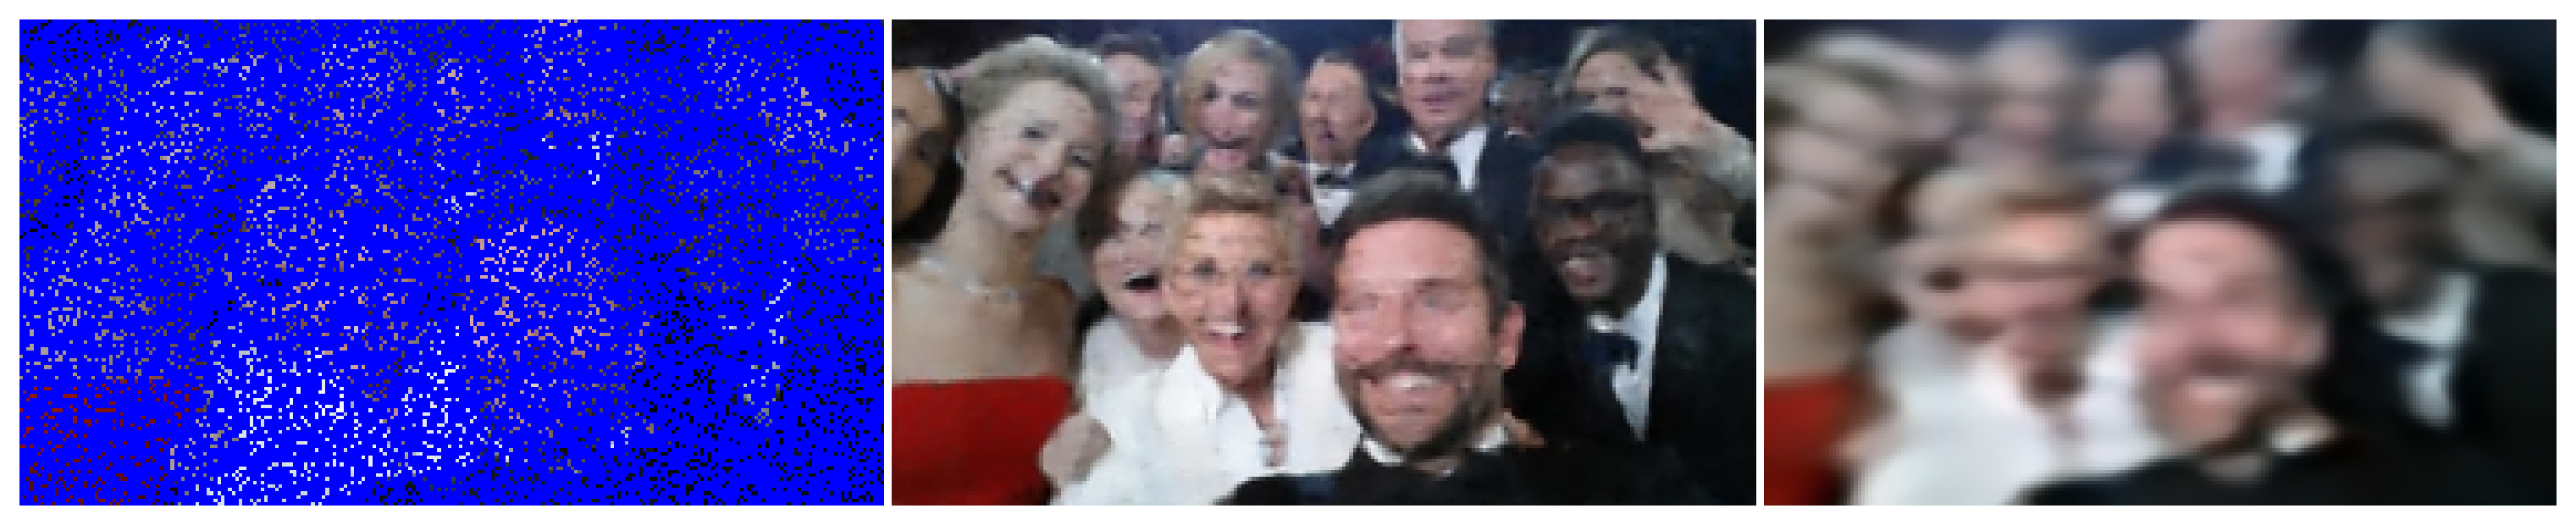

In [20]:
plot_concat(nnz=0.15)

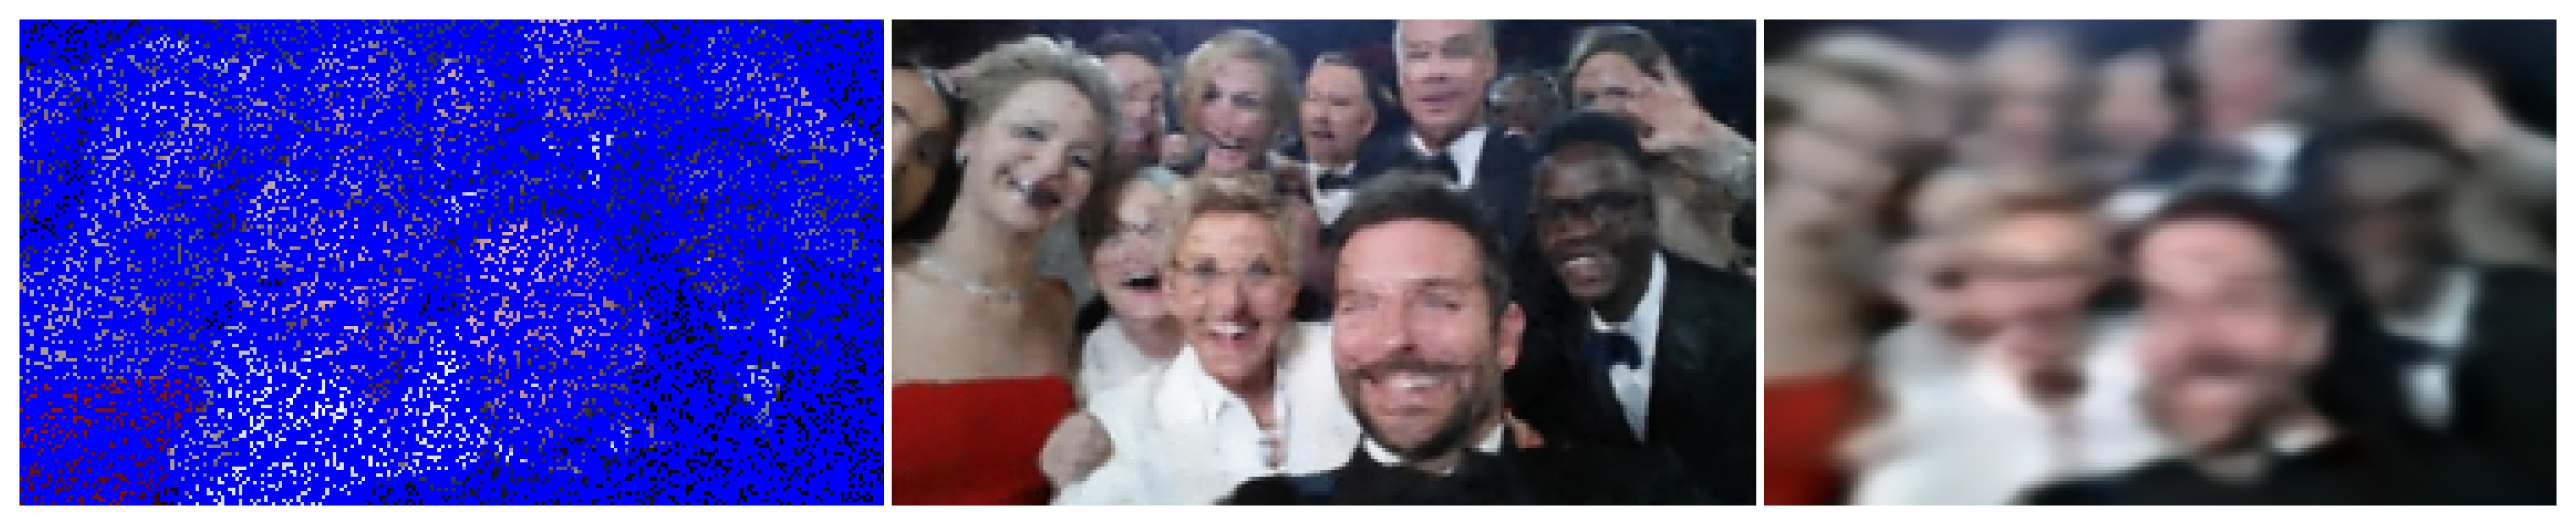

In [21]:
plot_concat(nnz=0.2)

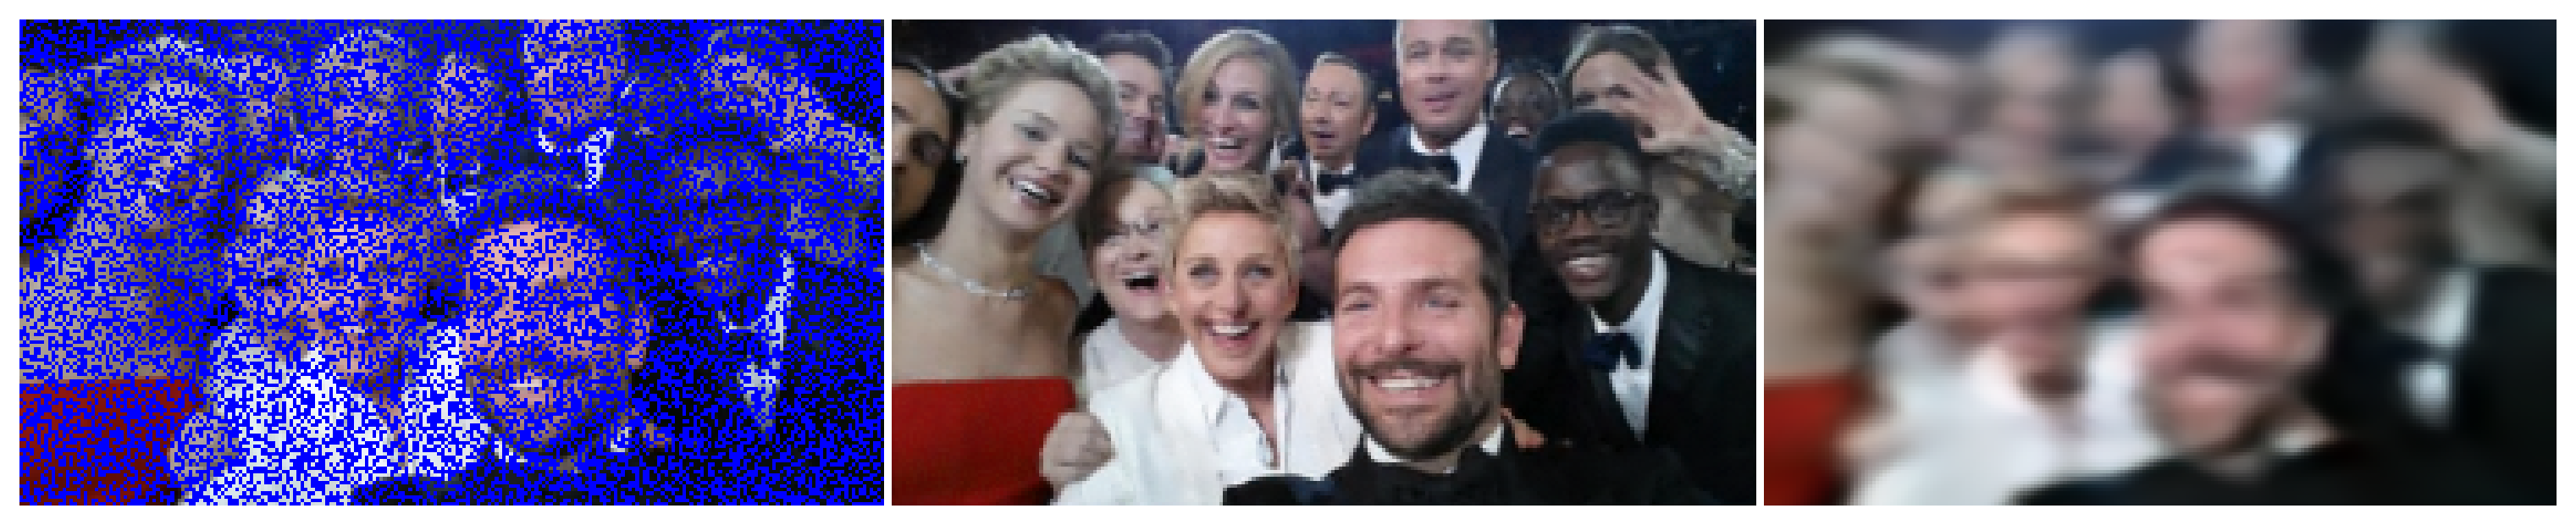

In [22]:
plot_concat(nnz=0.5)

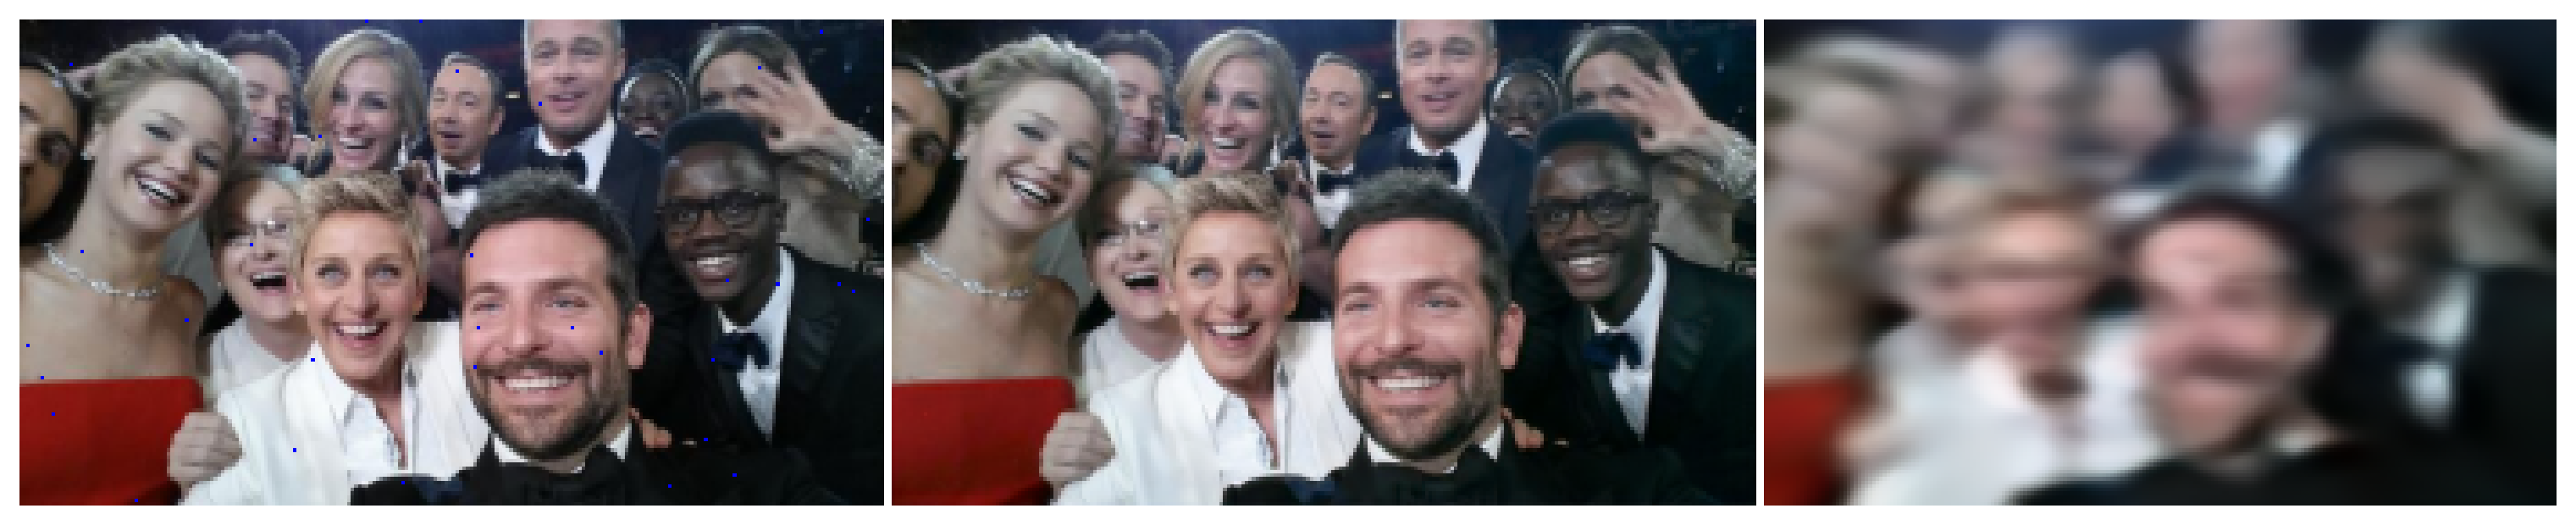

In [23]:
plot_concat(nnz=0.999)